Code for Maxwell-Stefan system

In [0]:
from __future__ import division
import numpy as np
from scipy.optimize import root, fsolve, broyden1
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  



Define the finite difference operator

In [0]:
def Df(u,h):
  return np.diff(np.append(u,[u[0]],axis=0),axis=0)/h
def df(u,h):
  return np.diff(np.append([u[-1]],u,axis=0),axis=0)/h

The solver class:
  u is like $[u_0,u_1,...,u_N]$ with each $u_i$ has $u_i^1,\ldots,u_i^n$ with $n$ being the species

In [0]:
Df([[1,2,3],[1,2,3]],1)

array([[0., 0., 0.],
       [0., 0., 0.]])

In [0]:
class MSsolver():
  def __init__(self,h,k,sp,bm,scope,uinitial, steps = 100000, savesteps=1):
    self.h = h
    self.k = k
    self.sp = sp
    self.x = np.linspace(scope[0],scope[1],(scope[1]-scope[0])/h+1)
    self.u0 = uinitial(self.x)
    self.u = self.u0
    self.uold = self.u0
    self.steps = steps
    if type(savesteps) == int:
      self.savesteps = range(0,steps,savesteps)
    else:
      self.savesteps = savesteps
    self.bm=bm
    # self.bm = np.full((sp,sp),1)
    # self.bm =self.bm- np.identity(sp)
    self.usol = [self.uold]
    self.tt=[0]
  def Bmatrix(self,u):
    Bmt = []
    for uu in u:
      s = np.zeros([len(uu),len(uu)])
      for i in range(len(uu)):
        for j in range(len(uu)):
          s[i,j] = self.bm[i,j]*uu[i]*uu[j]
          # s[i,j] = self.bm[i,j]
      # for i in range(len(uu)):
        # s[i,i] = np.sum(s[:,i])
      ss = np.sum(s,axis=0)
      tau_d = np.diag(ss) - s 
      tau = tau_d[:-1,:-1]
      Q = np.diag(1/uu) + 1/uu[-1]
      Q = Q[:-1,:-1]
      SS=np.linalg.inv(Q).dot(np.linalg.inv(tau)).dot(np.linalg.inv(Q))
      # SS=np.array([[uu[0]*(1-uu[0]),-uu[0]*uu[1]],[-uu[0]*uu[1],uu[1]*(1-uu[1])]])
      Bmt.append(SS)
    return Bmt
  def Nsh(self,uold):
    dd=[]
    for i in range(self.sp-1):
      dd.append(Df(np.log(self.u[:,i])-np.log(self.u[:,-1]),self.h))
      # dd.append(Df(self.u[:,i],self.h)/self.u[:,i] - Df(self.u[:,-1],self.h)/self.u[:,-1])
    dd = np.array(dd)
    uoldmiddle = np.zeros(uold.shape)
    # for i in range(len(self.uold[0,:])):
    #   uoldmiddle[:,i] = 	(np.roll(self.uold[:,i],-1)+self.uold[:,i])/2
    uoldmiddle=self.uold
    Bmt = self.Bmatrix(uoldmiddle)
    rhov = []
    for j in range(len(Bmt)):
      rhov.append(Bmt[j].dot(dd[:,j]))
    rhov = np.array(rhov)
    f = df(rhov,self.h)
    f = np.append(f,-np.array([np.sum(f,axis=1)]).T,axis=1)
    return f
  def forward_diff(self):
    self.uold = self.u
    self.u = self.u + self.k*self.Nsh(self.uold)
  def implicit(self):
    g = lambda u:(u - self.uold) - self.k* self.Nsh(self.u)
    sol=root(g,self.uold,method='df-sane')
    self.u=sol.x
    self.u = self.u + self.k*self.Nsh(self.u)
  def explicit_implicit(self):
    self.uold = self.u
    g = lambda u:(u - self.uold) - self.k* self.Nsh(self.uold)
    sol=root(g,self.uold,method='df-sane')
    self.u=sol.x
  def run(self,method='forward_diff'):
    self.method = method
    for i in range(self.steps+1):
      if method == 'forward_diff':
        self.forward_diff()	
      elif method == 'explicit_implicit':
        self.explicit_implicit()
      elif method == 'implicit':
        self.implicit()
      else:
        raise Exception('Method not defined!')
      if i in self.savesteps:
        self.usol.append(self.u)
        self.tt.append(self.k*i)
    self.usol = np.array(self.usol)

    




In [0]:
scope = np.array([0,1])
# uinitial = lambda x: np.array(list(zip(np.exp(-x/2)/4,1-np.exp(x/2)/2,np.exp(x/2)/4)))
# uinitial = lambda x: np.array(list(zip(x/2+0.1,0.6-x/2,0.5*(x>-1))))
def uinitial(x):
  # y = np.array(list(zip(0.7*(1-x/2),0.1*x+0.1)))
  y = np.array(list(zip(0.8*(x<0.25)+1.6*(0.75-x)*(x>=0.25)*(x<0.75)+0.0001*(x>=0.75),0.20*(x>-1)-0.0001)))
  # y = np.array(list(zip(0.9*(x<0.25)+1.6*(0.75-x)*(x>=0.25)*(x<0.75)+0.0001*(x>=0.75),0.0001*(x+1))))
  yy = 1 - y[:,0]-y[:,1]
  yy=np.array([yy])
  return np.append(y,yy.T,axis=1)

d12 = 1/0.833
d13 = 1/0.833
d23 = 1/0.168
bm=np.array([[0,d12,d13],[d12,0,d23],[d12,d23,0]])
# a = MSsolver(0.01,0.00001,3,bm,scope,uinitial)
a = MSsolver(0.02,0.00005,3,bm,scope,uinitial,10000)
# a.u

In [0]:
#a.run('forward_diff')
a.run('explicit_implicit')

(0, 0.8)

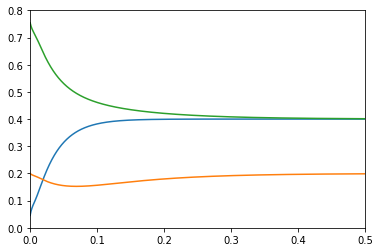

In [0]:
plt.plot(a.tt,a.usol[:,36,:])
axes = plt.gca()
axes.set_xlim([0,0.5])
axes.set_ylim([0,0.8])


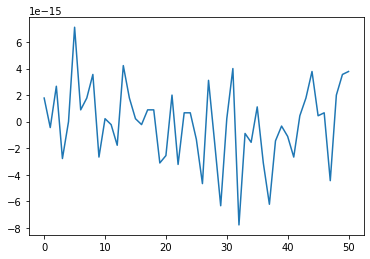

In [0]:
#plt.plot(np.sum(a.usol[-1,:,:],axis=0))
plt.plot([np.sum(a.usol[-1,i,:])-1 for i in range(len(a.usol[0,:,0]))])
# axes = plt.gca()
# axes.set_ylim([0.999,1.001])


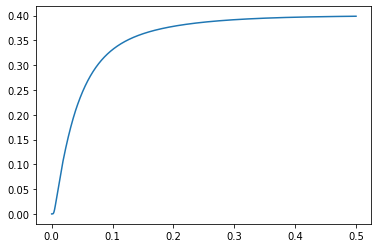

In [0]:
plt.plot(a.tt,[(np.min(a.usol[i,:,2])) for i in range(a.usol.shape[0])])
axes = plt.gca()
# axes.set_ylim([-10,0])


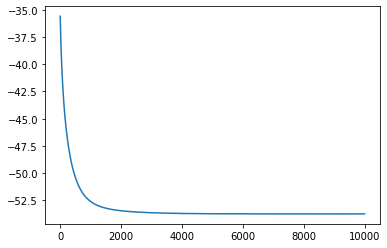

In [0]:
energyf = lambda u: np.sum(u*np.log(u))
plt.plot([energyf(a.usol[i,:,:]) for i in range(a.usol.shape[0])])

(-5e-14, 5e-14)

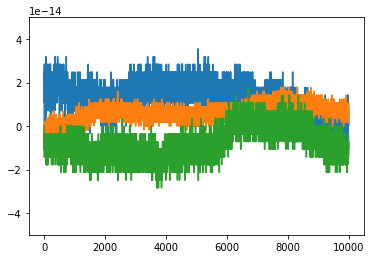

In [0]:
plt.plot([np.sum(a.usol[i,:,:],axis=0)-np.sum(a.usol[0,:,:],axis=0) for i in range(a.usol.shape[0])])
axes = plt.gca()
axes.set_ylim([-5e-14,5e-14])


(0, 0.8)

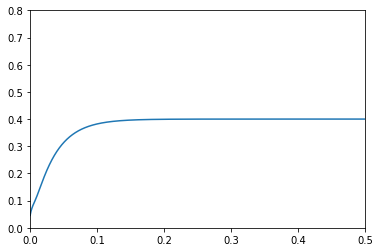

In [0]:
scope = np.array([0,1])
# uinitial = lambda x: np.array(list(zip(np.exp(-x/2)/4,1-np.exp(x/2)/2,np.exp(x/2)/4)))
# uinitial = lambda x: np.array(list(zip(x/2+0.1,0.6-x/2,0.5*(x>-1))))
def uinitial(x):
  # y = np.array(list(zip(0.7*(1-x/2),0.1*x+0.1)))
  y = np.array(list(zip(0.8*(x<0.25)+1.6*(0.75-x)*(x>=0.25)*(x<0.75)+0.0001*(x>=0.75),0.00020*(x>-1)-0.0001)))
  # y = np.array(list(zip(0.9*(x<0.25)+1.6*(0.75-x)*(x>=0.25)*(x<0.75)+0.0001*(x>=0.75),0.0001*(x+1))))
  yy = 1 - y[:,0]-y[:,1]
  yy=np.array([yy])
  return np.append(y,yy.T,axis=1)

d12 = 1/0.833
d13 = 1/0.833
d23 = 1/0.168
bm=np.array([[0,d12,d13],[d12,0,d23],[d12,d23,0]])
# a = MSsolver(0.01,0.00001,3,bm,scope,uinitial)
a = MSsolver(0.02,0.00005,3,bm,scope,uinitial,10000)
# a.u
a.run('forward_diff')
plt.plot(a.tt,a.usol[:,36,0])
axes = plt.gca()
axes.set_xlim([0,0.5])
axes.set_ylim([0,0.8])


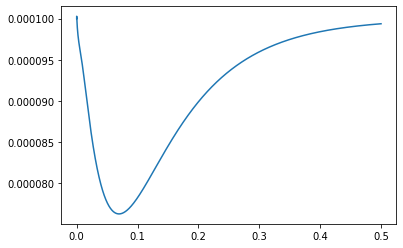

In [0]:
plt.plot(a.tt,a.usol[:,36,1])


(0, 0.1)

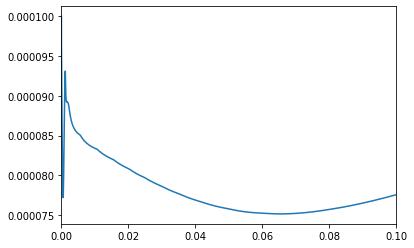

In [0]:
plt.plot(a.tt,[(np.min(a.usol[i,:,:])) for i in range(a.usol.shape[0])])
axes = plt.gca()
axes.set_xlim([0,0.1])
